# Test trees

In [1]:
import dendropy
from dendropy.calculate import treecompare
import logging
from collections import defaultdict
import itertools
import random
import math
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

taxa = dendropy.TaxonNamespace()
tree_str_1 = "[&R] ((R,((E,F)speciation,(G,H)duplication)speciation)speciation,(Q,((K,L)speciation,(J,I)speciation)speciation)duplication)duplication;"
##tree_1 = dendropy.Tree.get(
##        data=tree_str_1,
##        schema="newick", taxon_namespace = taxa)

tree_str_2 = "[&R] ((Q,((E,F)duplication,(G,H)speciation)speciation)speciation,(R,((K,L)speciation,(J,I)speciation)speciation)duplication)duplication;"
##tree_2 = dendropy.Tree.get(
##        data=tree_str_2,
##        schema="newick", taxon_namespace = taxa)

#tree_str_1 = "[&U] ((A,B)speciation, (C,D)speciation)speciation;"
#tree_str_2 = "[&U] ((A,C)speciation, (B,D)speciation)speciation;"
tree_str_3 = "[&R] ((A,B)speciation, (C,D)speciation);"
tree_str_4 = "[&R] ((A,C)speciation, (B,D)speciation);"

tree_1 = dendropy.Tree.get(
        data=tree_str_1,
        schema="newick", taxon_namespace = taxa)

tree_2 = dendropy.Tree.get(
        data=tree_str_2,
        schema="newick", taxon_namespace = taxa)

tree_3 = dendropy.Tree.get(
        data=tree_str_3,
        schema="newick", taxon_namespace = taxa)

tree_4 = dendropy.Tree.get(
        data=tree_str_4,
        schema="newick", taxon_namespace = taxa)

In [2]:
# Run the test on a much larger dataset
taxa2 = dendropy.TaxonNamespace()
t5 = dendropy.Tree.get_from_path('p53.nhx', 'newick', taxon_namespace=taxa2)
for n in t5.internal_nodes():
    if random.random() < 0.7:
        n.label = 'speciation'
    else:
        n.label = 'duplication'
t5.seed_node.label = None

## Function definitions

In [3]:
# make a copy and reroot
def cloneAndReroot(t):
  t1 = t.clone(depth=1)
  # reroot around the edge leading to the first leaf
  l = next(t1.leaf_node_iter())
  t1.reroot_at_edge(l.incident_edges()[0])
  return(t1)


In [4]:
def identify_labelled_bipartitions(t):
  
    t.encode_bipartitions()

    def recursive_f(n,bipart,bipart2nodes,numTaxa):
        if n.is_leaf():
            return
        for c in n.child_node_iter():
            if not c.is_leaf():
                numTaxaC = bin(c.bipartition.split_bitmask).count('1')
                numTaxaN = numTaxa - numTaxaC

                # at the start of the recursion, one subtree might contain all taxa 
                # minus the other one so we must ignore this trivial bipartition
                if numTaxaN > 1:
                    bipart.append(c.bipartition)
                    bipart2nodes[c.bipartition] = [c,n]
                recursive_f(c,bipart,bipart2nodes,numTaxa)
                
    numTaxa = len(t.leaf_nodes())
    bipart = []
    bipart2nodes = {}
    recursive_f(t.seed_node,bipart,bipart2nodes,numTaxa)
    return(bipart,bipart2nodes)

In [5]:
def LRF(intree1,intree2):
    t1 = intree1.clone()
    t2 = intree2.clone()
    b1,bTn1 = identify_labelled_bipartitions(t1)
    b2,bTn2 = identify_labelled_bipartitions(t2)

    # FIRST PART:  identifying the bipartitions unique to one or the other tree
    #              and collapsing the trivial edges
    tocollapse1 = []
    tocollapse2 = []
    simple_rf = tot_rf = path_flip = 0
    for k in set(b1).difference(set(b2)):
        logging.info(k)
        # retrieve the nodes associated with the bipartition
        [c,n] = bTn1[k]
        if c.label == n.label:
            logging.info('collapsing node %s' % c)
            c.edge.collapse()
            simple_rf += 1
        else:
            tocollapse1.append(k)
    logging.info('---')
    for k in set(b2).difference(set(b1)):
        logging.info(k)
        # retrieve the nodes associated with the bipartition
        [c,n] = bTn2[k]
        if c.label == n.label:
            logging.info("collapsing node %s" % c)
            c.edge.collapse()
            simple_rf += 1
        else:
            tocollapse2.append(k)
    logging.info('***')        
    print('step 1, collapse consistent edges: %d' % simple_rf)

    # PART II:  identifying the connected components of edges to be 
    #           collapsed and recording the ends of the longest path
    #
    # The idea of this function is to go from root to leaves,
    # and then, on the way back, compute the longest path of
    # each component to be collapsed.
    # Within each component, we need to keep track of three potential 
    # cases: 
    #  (1) the longest path spans over the edge (n.edge) in question,
    #      in which case its total length is still undetermined 
    #  (2) the longest path spans over two of the children of n. In
    #      this case the length is known but the type needs to be
    #      determined
    #  (3) the longest path is found somewhere deeper. We need to keep
    #      track of its type.
    #
    # Note that the longest path is highlighted with ****
    #
    #                                   ------
    #                                 /
    #                     **************************
    #                   *
    #   ****n.edge**** n      (case 1)
    #                   \
    #                     -----------------
    #
    #                                   ------
    #                                 /
    #                     **************************
    #                   *
    #   ---n.edge---- n      (case 2)
    #                   *
    #                     **********************
    #
    #
    #                                   ************
    #                                 *
    #                     ------------**************
    #                   /
    #   ---n.edge---- n      (case 3)
    #                   \
    #                     ---------------

    # a helpful datastructure to store a path
    class maxpath(object):
        def __init__(self, length=0, n1=None, n2=None):
            self.length = length
            self.n1 = n1
            self.n2 = n2
        def __cmp__(self, other):
            return(cmp(self.length, other.length))
        def __lt__(self, other):
            return(self.length < other.length)
        def __eq__(self, other):
            return(self.length == other.length)
        def __str__(self):
            return('Path length: %d. Ends %s & %s' % (self.length, self.n1, self.n2))

    def recursive_f(n,tocollapse,out):
        nonlocal path_flip
        if n.is_leaf():
            return([maxpath(),maxpath()])
        case1 = []
        case3 = []
        for c in n.child_node_iter():
            [t1,t3] = recursive_f(c,tocollapse,out)
            case1.append(t1)
            case3.append(t3)
        case1.sort(reverse=True)
        case3.sort(reverse=True)
        # do we need to collapse the edge in question?
        if n.bipartition in tocollapse:
            # if the maximum path goes over the edge n, we need
            # to increment the length in question
            newcase1 = copy.deepcopy(case1[0])
            if case1[0].length == 0:
                newcase1.n1 = copy.deepcopy(n)
            newcase1.length = newcase1.length + 1
            # if not, we keep track of the longest path in the component
            # seen so far (case 3)
            newcase3 = copy.deepcopy(case3[0])
            # if there are more than one child edge to collapse,
            # there is one last scenario, which is that the longest path
            # is obtained by connecting two children edges (case 2)
            if case1[0].length + case1[1].length > case3[0].length:
                # store the total length
                newcase3.length = case1[0].length+case1[1].length
                # store the end nodes
                newcase3.n1 = case1[0].n1
                newcase3.n2 = case1[1].n1
            return([newcase1,newcase3])
        else:
            # if one of the children was still part of a component,
            # we need to store it
            if sum([c.length for c in case1]) > 0:
                # we need to check what is the maximum length path
                if case1[0].length > case3[0].length:
                    # longest path is case 1 or case 2
                    if case1[1].length > 0:
                        # longest path is case 2
                        bestpath = maxpath(case1[0].length + case1[1].length, case1[0].n1, case1[1].n1)
                        if bestpath.length % 2 == 0:
                            assert bestpath.n1.label == bestpath.n2.label
                        else:
                            assert bestpath.n1.label != bestpath.n2.label 
                    else:
                        bestpath = case1[0]
                        bestpath.n2 = copy.deepcopy(n)
                        # longest path is case 1
                        if bestpath.length % 2 == 0:
                            assert n.label == bestpath.n1.label
                        else:
                            assert n.label != bestpath.n1.label

                else:
                    # longest path is case3
                    bestpath = case3[0]

                path_flip += math.floor((bestpath.length+1)/2)
                out[n] = bestpath
                # determine type
                if bestpath.length % 2 == 0:
                    n.label = bestpath.n1.label
                else:
                    n.label = "arbitrary"
            # reset counts
            return([maxpath(),maxpath()])
    
    path_flip = 0
    tot_rf = simple_rf + len(tocollapse1) + len(tocollapse2)
    out1 = {}
    recursive_f(t1.seed_node,tocollapse1,out1)
    out2 = {}
    recursive_f(t2.seed_node,tocollapse2,out2)
    for n in t1.internal_nodes():
        if n.bipartition in tocollapse1:
            n.edge.collapse()
    for n in t2.internal_nodes():
        if n.bipartition in tocollapse2:
            n.edge.collapse()
                    
                    
    logging.info('  #component t1 %d', len(out1))
    logging.info(out1)
    logging.info('  #component t2 %d', len(out2))
    logging.info(out2)
    logging.info('  #flips %d', path_flip)
    logging.info(t1)
    logging.info(t2)
    logging.info(t1.as_ascii_plot())

    ## PART 3:  flipping the nodes, if needed, and checking whether
    ##    arbitary vs arbitrary comparisons can save a flip by going
    ##    over an expansion instead of a contraction.
    
    def ordered_bipartitions(tree):
        leaves_dic = {}
        for node in tree.internal_nodes():
            leaves_dic[tuple(sorted(nd.taxon.label for nd in dendropy.Tree(seed_node = node).leaf_nodes()))] = node
        return leaves_dic

    ob1 = ordered_bipartitions(t1)
    ob2 = ordered_bipartitions(t2)

    
    def branches_at_end(path,tocollapse):
        tc1 = set([t.split_bitmask for t in tocollapse])

        s1 = [t.bipartition.split_bitmask for t in path.n1.child_nodes()]
        s1.append(path.n1.bipartition.split_bitmask)
        s1 = set(s1)
        s1 = s1.difference(tc1)

        s2 = [t.bipartition.split_bitmask for t in path.n2.child_nodes()]
        s2.append(path.n2.bipartition.split_bitmask)
        s2 = set(s2)
        s2 = s2.difference(tc1)

        # convention is return speciation, then duplication node
        if path.n1.label == 'speciation':
            return([s1,s2])
        else:
            return([s2,s1])

    end_flip = 0
    for b in ob1:
        if (ob1[b].label == "speciation" and ob2[b].label == "duplication") or (
            ob1[b].label == "duplication" and ob2[b].label == "speciation"):
            end_flip += 1
        elif (ob1[b].label == "arbitrary" and ob2[b].label == "arbitrary"):
            # let's check if we can save a flip
            
            [s1,s2] = branches_at_end(out1[ob1[b]],tocollapse1)
            [s3,s4] = branches_at_end(out2[ob2[b]],tocollapse2)
            logging.info(s1,s2,s3,s4)
            
            # To be able to save a flip via expansion, one end has to
            # contain all of the branches of its corresponding end in
            # the other tree, e.g. like so: 
            #
            #      s1              s2          s3            s4
            #  {b1,b2,b3}S-----D{b4,b5} vs. {b1,b2}S-----D{b3,b4,b5}  
            #  
            # (s3 contained in s1, and s2 contained in s4). 
            # Note that the end type have to match.
            if (bool(s1.difference(s3)) or bool(s3.difference(s1)) or 
                bool(s2.difference(s4)) or bool(s4.difference(s2))):
                end_flip -= 1
            logging.info('Matching islands are both of type arbitrary & can save a flip!')
    print('step 3, perform remaining flips ', end_flip)
    erf = tot_rf+path_flip+end_flip
    print('**TOTAL** extended RF dist:', erf)
    return(erf)
    

In [6]:
## The following function definitions are used to introduce random edits

def collapse_node(node):
    add_flip = 0
    if node.parent_node != None and node.label == node.parent_node.label:
        node.edge.collapse()
    else:
        raise ValueError('this edge cannot be collapsed without a flip!')
    return add_flip
def flip_node(node):
    if node.label == 'speciation':
        node.label = 'duplication'
    elif node.label == 'duplication':
        node.label = 'speciation'
    else:
        raise ValueError('Should not happen!!')
        number = random.randint(1,2)
        if number == 1:
            node.label = "speciation"
        if number == 2:
            node.label = "duplication"
            
## Note by CD: I have simplified and cleaned up the code. See my version below
def extend_node2(node):
    if len(node.adjacent_nodes())<= 3:
        raise ValueError("Insufficient degree")
    
    tree_test = tree_1.clone()
    tmp = node
    modif = node.child_nodes()
    random_number = random.randint(1, len(modif) - 2)
    partition = modif[random_number:len(modif)]
    subtrees_modif = []
    for nd in partition:
        subtrees_modif.append(dendropy.Tree(seed_node = nd).leaf_nodes())
    subtrees_modif = [item for sublist in subtrees_modif for item in sublist]
    subtrees_modif = [node.taxon.label for node in subtrees_modif]
    tree_test.retain_taxa_with_labels(subtrees_modif)
    tmp.add_child(tree_test.seed_node)
    return tree_1.as_ascii_plot()

def extend_node(node):
    if len(node.adjacent_nodes())<= 3:
        print(node.adjacent_nodes(),node.incident_edges())
        raise ValueError("Insufficient degree. Should not happen")
    # store the children in a temporary array
    children = node.child_nodes()
    # shuffle the array
    random.shuffle(children)
    
    
    node.clear_child_nodes()
    new = node.add_child(dendropy.Node(label=node.label))
    # choose between 2 and n-1 children to be connected to the new node
    k = random.randint(2,len(children)-1) 
    for i in range(0,len(children)):
        # add the first k 
        if i < k:
            new.add_child(children[i])
        else:
            node.add_child(children[i])


def mutateLabeledTree(tree, n):
    e = f = c = 0
    for i in range(0, n):
        logging.info(i)
        #potential nodes

        potential_nodes_to_collapse = []
        for n in tree.internal_nodes():
            #skip the root node
            if n.parent_node == None:
                continue
            if n.label == n.parent_node.label and n.label != None:
                potential_nodes_to_collapse.append(n)
        potential_nodes_to_flip = [n for n in tree.internal_nodes() if n.label != None]
        potential_nodes_to_expand = [n for n in tree.internal_nodes() if 
                                     len(n.incident_edges()) > 3 and n != tree.seed_node]
        
        
        ncol = len(potential_nodes_to_collapse)
        nflip = len(potential_nodes_to_flip)
        nexp = len(potential_nodes_to_expand)
        
        # 30% chance of flipping
        if random.random() < 0.3:
            flip_node(potential_nodes_to_flip[random.randint(0,nflip-1)])
            f += 1
        else:
            x = random.randint(0,ncol+nexp-1)
            if x < ncol:
                collapse_node(potential_nodes_to_collapse[x])
                c += 1
            else:
                e += 1
                extend_node(potential_nodes_to_expand[x-ncol])
        logging.info(tree)
    logging.info('#flips %s #col %s, #exp %s',f,c,e)
    return(tree)

## Data analysis

In [7]:
# Simulation & computation

t = cloneAndReroot(t5)
random.seed(12)
abort = False
res = [0]*20
res_rf = [0]*20
logging.root.level = 40
for i in range(1,15):
    if abort:
        break
    res.append([])
    res_rf.append([])
    for j in range(0,20):
        #if i == 4 and j == 12:
        #    abort = True
        #    break
        t2 = mutateLabeledTree(t.clone(depth=1), i)
        
        res[i].append(LRF(t,t2))
        res_rf[i].append(treecompare.symmetric_difference(t,t2))
        t = t2;


AttributeError: 'int' object has no attribute 'append'

In [8]:
x = np.array(res)
y = x.transpose()
df = pd.DataFrame(y)
print('Labelled Robinson Foulds:')
df.plot.box()

ValueError: setting an array element with a sequence.

Standard Robinson Foulds:


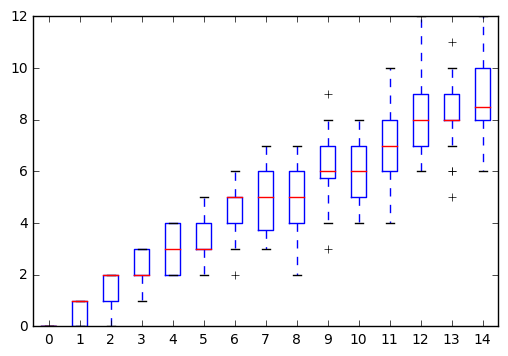

In [1880]:
x = np.array(res_rf)
y = x.transpose()
df = pd.DataFrame(y)
print('Standard Robinson Foulds:')
df.plot.box()

## Testing the code

In [1451]:
logging.root.level = 20
print(t)
t.print_plot()
t2 = mutateLabeledTree(t.clone(depth=1), 4)
t1 = t.clone(depth=1)
print(t2)
t2.print_plot()

INFO:root:0
INFO:root:(R,((H,G,E,(Q,L)speciation)duplication,K,(I,F)speciation,J)duplication)
INFO:root:1
INFO:root:(R,((H,G,E,(Q,L)speciation)duplication,K,(I,F)speciation,J)speciation)
INFO:root:2
INFO:root:(R,((H,G,E,(Q,L)speciation)duplication,K,I,F,J)speciation)
INFO:root:3
INFO:root:(R,(((H,E,(Q,L)speciation)duplication,G)duplication,K,I,F,J)speciation)
INFO:root:#flips 1 #col 1, #exp 2


(R,(H,(Q,L)speciation,E,K,G,(I,F)speciation,J)duplication)
/---------------------------------------------------------------------------- R
|                                                                              
|                        /--------------------------------------------------- H
|                        |                                                     
|                        |                         /------------------------- Q
+                        |-------------------------+                           
|                        |                         \------------------------- L
|                        |                                                     
|                        |--------------------------------------------------- E
|                        |                                                     
\------------------------+--------------------------------------------------- K
                         |                                   

In [1452]:
LRF(t1,t2)

INFO:root:1000000100
INFO:root:---
INFO:root:0010111010
INFO:root:0010110010
INFO:root:collapsing node <Node object at 0x10a2d95c0: 'duplication' (None)>
INFO:root:***
INFO:root:  #component t1 1
INFO:root:{<Node object at 0x109dbef28: 'arbitrary' (None)>: <__main__.LRF.<locals>.maxpath object at 0x10a320048>}
INFO:root:  #component t2 1
INFO:root:{<Node object at 0x10a2d9e48: 'arbitrary' (None)>: <__main__.LRF.<locals>.maxpath object at 0x10a319fd0>}
INFO:root:  #flips 2
INFO:root:(R,(H,(Q,L)speciation,E,K,G,I,F,J)arbitrary)
INFO:root:(R,(H,E,(Q,L)speciation,G,K,I,F,J)arbitrary)
INFO:root:/---------------------------------------------------------------------------- R
|                                                                              
|                        /--------------------------------------------------- H
|                        |                                                     
|                        |                         /------------------------- Q
+  

step 1, collapse consistent edges: 1
{('E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'Q'): <Node object at 0x109dbef28: 'arbitrary' (None)>, ('L', 'Q'): <Node object at 0x109dbe588: 'speciation' (None)>, ('E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'Q', 'R'): <Node object at 0x109dbe470: 'None' (None)>}
-
{('E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'Q'): <Node object at 0x10a2d9e48: 'arbitrary' (None)>, ('L', 'Q'): <Node object at 0x10a2d9630: 'speciation' (None)>, ('E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'Q', 'R'): <Node object at 0x10a2d9f28: 'None' (None)>}
{512, 4} {64, 160, 2, 256, 8, 16, 1022} {64, 512, 4, 256, 1022} {16, 8, 2, 160}
step 3, perform remaining flips  -1
**TOTAL** extended RF dist: 4


4

# Legacy code by Gabriela

## A) Identifying

In [4]:
# Comment by CD: the code has a mistake in that it also returns a "trivial" bipartition 
# with one taxon on one side (R) and all others on the other side.

def id_bipartitions_and_linkers(tree):
    tree.encode_bipartitions()
    linkers_bipartitions = {}
    labeled_nodes = [node for node in tree if node.label]
    for node in labeled_nodes:
        if len(node.bipartition.leafset_taxa(taxon_namespace = tree.taxon_namespace))>1:
            #if node.parent_node in labeled_nodes:
            linkers_bipartitions[tuple(sorted([nd.label for nd in node.bipartition.leafset_taxa(taxon_namespace = tree.taxon_namespace)]))] = (node, node.parent_node)
    return linkers_bipartitions

# testing:
for element in id_bipartitions_and_linkers(t1):
    print (element, id_bipartitions_and_linkers(t1)[element])
print ("\n")
print ("There are", len(id_bipartitions_and_linkers(t1)), "bipartitions.")

('E', 'F', 'G', 'H') (<Node object at 0x1098bc160: 'speciation' (None)>, <Node object at 0x1098bc278: 'speciation' (None)>)
('E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'Q') (<Node object at 0x1098bc278: 'speciation' (None)>, <Node object at 0x109c87668: 'None' (None)>)
('I', 'J', 'K', 'L') (<Node object at 0x109c77c18: 'speciation' (None)>, <Node object at 0x109838f60: 'duplication' (None)>)
('I', 'J', 'K', 'L', 'Q') (<Node object at 0x109838f60: 'duplication' (None)>, <Node object at 0x1098bc278: 'speciation' (None)>)
('E', 'F') (<Node object at 0x1098bc1d0: 'speciation' (None)>, <Node object at 0x1098bc160: 'speciation' (None)>)
('G', 'H') (<Node object at 0x109838fd0: 'duplication' (None)>, <Node object at 0x1098bc160: 'speciation' (None)>)
('K', 'L') (<Node object at 0x109c77eb8: 'speciation' (None)>, <Node object at 0x109c77c18: 'speciation' (None)>)
('I', 'J') (<Node object at 0x109c87940: 'speciation' (None)>, <Node object at 0x109c77c18: 'speciation' (None)>)


There are 8 biparti

In [190]:
# note CD: some bipartitions are counted twice (e.g. ('E', 'F', 'G', 'H', 'R') == ('I', 'J', 'K', 'L', 'Q'))

def id_differing(tree_1, tree_2):
    differing_bipartitions = set(id_bipartitions_and_linkers(tree_1).keys()).symmetric_difference(set(id_bipartitions_and_linkers(tree_2)))
    return differing_bipartitions
differing_bipartitions = id_differing(tree_1,tree_2)

tree_1_edges = [id_bipartitions_and_linkers(tree_1)[element] for element in differing_bipartitions if element in id_bipartitions_and_linkers(tree_1).keys()]
tree_2_edges = [id_bipartitions_and_linkers(tree_2)[element] for element in differing_bipartitions if element in id_bipartitions_and_linkers(tree_2).keys()]

diff_same_tree_1 = [element for element in tree_1_edges if element[0].label == element[1].label]
diff_same_tree_2 = [element for element in tree_2_edges if element[0].label == element[1].label]


# testing
print ("The set of differing biparitions is:", differing_bipartitions, "\n")


print ("All the edges that will be collapsed in tree_1", tree_1_edges)
print ("All the edges that will be collapsed in tree_2", tree_2_edges)
print ("\n")
print ("The edges that will be collapsed in this first step in tree 1 are:")
for elem in range(0, len(diff_same_tree_1)):
    print (diff_same_tree_1[elem], "\n")
print ("The edges that will be collapsed in this first step in tree 2 are:")
for elem in range(0, len(diff_same_tree_2)):
    print (diff_same_tree_2[elem], "\n")
print ("\n")

The set of differing biparitions is: {('E', 'F', 'G', 'H', 'R'), ('E', 'F', 'G', 'H', 'Q'), ('I', 'J', 'K', 'L', 'Q'), ('I', 'J', 'K', 'L', 'R')} 

All the edges that will be collapsed in tree_1 [(<Node object at 0x109c77da0: 'speciation' (None)>, <Node object at 0x109c77d30: 'duplication' (None)>), (<Node object at 0x109c87518: 'duplication' (None)>, <Node object at 0x109c77d30: 'duplication' (None)>)]
All the edges that will be collapsed in tree_2 [(<Node object at 0x109c87cf8: 'speciation' (None)>, <Node object at 0x109c87c88: 'duplication' (None)>), (<Node object at 0x109c8a128: 'duplication' (None)>, <Node object at 0x109c87c88: 'duplication' (None)>)]


The edges that will be collapsed in this first step in tree 1 are:
(<Node object at 0x109c87518: 'duplication' (None)>, <Node object at 0x109c77d30: 'duplication' (None)>) 

The edges that will be collapsed in this first step in tree 2 are:
(<Node object at 0x109c8a128: 'duplication' (None)>, <Node object at 0x109c87c88: 'duplicat

## B) Collapsing

In [27]:
for element in diff_same_tree_1: element[0].edge.collapse()
for element in diff_same_tree_2: element[0].edge.collapse()

# testing

print ("The first tree is now", tree_1)
print ("The differing bipartitions are now only", id_differing(tree_1, tree_2))

The first tree is now ((R,((E,F)speciation,(G,H)duplication)speciation)speciation,Q,((K,L)speciation,(J,I)speciation)speciation)duplication
The differing bipartitions are now only {('E', 'F', 'G', 'H', 'Q'), ('E', 'F', 'G', 'H', 'R')}


In [28]:
tree_1.print_plot()
tree_2.print_plot()

                   /--------------------------------------------------------- R
                   |                                                           
/------------------+                                     /------------------- E
|                  |                  /------------------+                     
|                  |                  |                  \------------------- F
|                  \------------------+                                        
|                                     |                  /------------------- G
|                                     \------------------+                     
+                                                        \------------------- H
|                                                                              
|---------------------------------------------------------------------------- Q
|                                                                              
|                                       

In [645]:
random.randint(2,2)

2

In [14]:
diff_same_tree_1[0].edge

AttributeError: 'tuple' object has no attribute 'edge'

## C) How many operations to be added to extended Robinson-Foulds?

In [6]:
erf = 0
erf += len(diff_same_tree_1)+ len(diff_same_tree_2)

#testing

print (erf)

2


# 2) Dealing with diff_diff bipartitions

## A) Identifying

In [7]:
for element in id_bipartitions_and_linkers(tree_1):
    print (id_bipartitions_and_linkers(tree_1)[element])
print ("\n")
print ("There are", len(id_bipartitions_and_linkers(tree_1)), "bipartitions in tree 1.")
print ("There are", len(id_bipartitions_and_linkers(tree_2)), "bipartitions in tree 2.")

(<Node object at 0x4397fd0: 'duplication' (None)>, <Node object at 0x4397e70: 'speciation' (None)>)
(<Node object at 0x4397dd0: 'speciation' (None)>, <Node object at 0x4397d90: 'duplication' (None)>)
(<Node object at 0x43ac230: 'speciation' (None)>, <Node object at 0x43ac1f0: 'speciation' (None)>)
(<Node object at 0x4397eb0: 'speciation' (None)>, <Node object at 0x4397e70: 'speciation' (None)>)
(<Node object at 0x4397d90: 'duplication' (None)>, None)
(<Node object at 0x4397e70: 'speciation' (None)>, <Node object at 0x4397dd0: 'speciation' (None)>)
(<Node object at 0x43ac1f0: 'speciation' (None)>, <Node object at 0x4397d90: 'duplication' (None)>)
(<Node object at 0x43ac350: 'speciation' (None)>, <Node object at 0x43ac1f0: 'speciation' (None)>)


('There are', 8, 'bipartitions in tree 1.')
('There are', 8, 'bipartitions in tree 2.')


In [8]:
differing_bipartitions = id_differing(tree_1,tree_2)

tree_1_edges = [id_bipartitions_and_linkers(tree_1)[element] for element in differing_bipartitions if element in id_bipartitions_and_linkers(tree_1).keys()]
tree_2_edges = [id_bipartitions_and_linkers(tree_2)[element] for element in differing_bipartitions if element in id_bipartitions_and_linkers(tree_2).keys()]

diff_diff_tree_1 = [element for element in tree_1_edges if element[0].label != element[1].label]
diff_diff_tree_2 = [element for element in tree_2_edges if element[0].label != element[1].label]

# testing
print (differing_bipartitions)
print ("The edges that will be collapsed in tree 1 in this step are", diff_diff_tree_1)
print ("The edges that will be collapsed in tree 2 in this step are", diff_diff_tree_2)


set([('E', 'F', 'G', 'H', 'R'), ('E', 'F', 'G', 'H', 'Q')])
('The edges that will be collapsed in tree 1 in this step are', [(<Node object at 0x4397dd0: 'speciation' (None)>, <Node object at 0x4397d90: 'duplication' (None)>)])
('The edges that will be collapsed in tree 2 in this step are', [(<Node object at 0x43ac530: 'speciation' (None)>, <Node object at 0x43ac4f0: 'duplication' (None)>)])


## B) Organizing in subtrees

In [14]:
def adjacent_edges(node,diff):
    output = []
    for edge in diff:
        if node in edge:
            output.append(edge)
    return output

visited = {}
for edge in diff_diff_tree_1:
    visited[edge] = False

def explore(node,orig,diff, subtree = defaultdict(set)):
    for edge in adjacent_edges(node,diff):
        if edge == orig:
            continue
        else:
            if edge[0] == node:
                dest = edge[1]
            else:
                dest = edge[0]
        subtree[node].add(dest)
        subtree[dest].add(node)
        orig = edge
        explore(dest,orig,diff)
    return subtree


subtrees_tree_1 = []
subtrees_tree_2 = []
nodes_tree_1 = set(list(itertools.chain(*diff_diff_tree_1)))
nodes_tree_2 = set(list(itertools.chain(*diff_diff_tree_2)))

for node in nodes_tree_1:
    subtree = defaultdict(set)
    if explore(node, None, diff_diff_tree_1, subtree = subtree) not in subtrees_tree_1:    
        subtrees_tree_1.append(explore(node, None, diff_diff_tree_1, subtree = subtree))
        
for node in nodes_tree_2:
    subtree = defaultdict(set)
    if explore(node, None, diff_diff_tree_2, subtree=subtree) not in subtrees_tree_2:   
        subtrees_tree_2.append(explore(node, None, diff_diff_tree_2, subtree= subtree))

for i in range(0, len(subtrees_tree_1)): 
    subtrees_tree_1[i] = dict(subtrees_tree_1[i])
    for j in subtrees_tree_1[i]:
        subtrees_tree_1[i][j] = list(subtrees_tree_1[i][j])
for i in range(0, len(subtrees_tree_2)): 
    subtrees_tree_2[i] = dict(subtrees_tree_2[i])
    for j in subtrees_tree_2[i]:
        subtrees_tree_2[i][j] = list(subtrees_tree_2[i][j])

print (subtrees_tree_1)
print (subtrees_tree_2)

[{<Node object at 0x4397dd0: 'speciation' (None)>: [<Node object at 0x4397d90: 'duplication' (None)>], <Node object at 0x4397d90: 'duplication' (None)>: [<Node object at 0x4397dd0: 'speciation' (None)>]}]
[{<Node object at 0x43ac530: 'speciation' (None)>: [<Node object at 0x43ac4f0: 'duplication' (None)>], <Node object at 0x43ac4f0: 'duplication' (None)>: [<Node object at 0x43ac530: 'speciation' (None)>]}]


## C) Longest chains for all subtrees

In [16]:
def bfs(start, adj):
    distances = {}
    distances[start] = None
    i = 1
    frontier = [start]
    while len(frontier)>0:
        next_array = []
        for u in frontier:
            for v in adj[u]:
                if v not in distances:
                    distances[v]=i
                    next_array.append(v)
        frontier = next_array
        i+=1
    return distances

for i in range(0, len(subtrees_tree_1)):
    print (bfs(list(nodes_tree_1)[0], subtrees_tree_1[i]))
    
import math 

def longest_distance(distances):
    values = list(distances.values())
    keys = list(distances.keys())
    return keys[values.index(max(values))], max(values)

list_of_chains = []
end_types_1 = []
end_types_2 = []

for i in range(0, len(subtrees_tree_1)):
    print list(nodes_tree_1)[0]
    first_node =  longest_distance(bfs(list(nodes_tree_1)[0], subtrees_tree_1[i]))[0]
    furthest_node = longest_distance(bfs(first_node,subtrees_tree_1[i]))[1]
    list_of_chains.append(furthest_node)
    if furthest_node % 2 == 1:
        if (furthest_node - math.ceil(furthest_node/2))%2 == 0:
            end_type = first_node.label
        else:
            if first_node.label == "speciation":
                end_type = "duplication"
            elif first_node.label == "duplication":
                end_type = "speciation"
    elif furthest_node % 2 == 0:
        end_type = "undetermined"
    end_types_1.append(end_type)

for i in range(0, len(subtrees_tree_2)):
    first_node =  longest_distance(bfs(list(nodes_tree_2)[0], subtrees_tree_2[i]))[0]
    furthest_node = longest_distance(bfs(first_node,subtrees_tree_2[i]))[1]
    list_of_chains.append(furthest_node)
    if furthest_node % 2 == 1:
        if (furthest_node - math.ceil(furthest_node/2))%2 == 0:
            end_type = first_node.label
        else:
            if first_node.label == "speciation":
                end_type = "duplication"
            elif first_node.label == "duplication":
                end_type = "speciation"
    elif furthest_node % 2 == 0:
        end_type = "undetermined"
    end_types_2.append(end_type)
    
print (end_types_1)
print (end_types_2)

print ("List of chain lengths", list_of_chains)
flips = 0
for i in list_of_chains:
    if i == 1:
        flips += 1
    elif i > 1:
        flips += math.floor(i/2)
        
print ("Total number of flips is", int(flips))

{<Node object at 0x4397dd0: 'speciation' (None)>: None, <Node object at 0x4397d90: 'duplication' (None)>: 1}
<Node object at 0x4397dd0: 'speciation' (None)>
['speciation']
['speciation']
('List of chain lengths', [1, 1])
('Total number of flips is', 2)


## D) Collapsing 

In [ ]:
def family_edges(subtrees_tree_1, diff_diff_tree_1):
    family_edges_1 = []
    for subtree in subtrees_tree_1:
        family = subtree.keys()
        family_edges = []
        for edge in diff_diff_tree_1:
            for key in family:
                if key in edge:
                    family_edges.append(edge)
        family_edges_1.append(list(set(family_edges)))
    return family_edges_1


for family in range(0, len(family_edges(subtrees_tree_1, diff_diff_tree_1))):
    for element in family_edges(subtrees_tree_1, diff_diff_tree_1)[family]:
        element[0].edge.collapse()
        final_node = element[1]
    final_node.label = end_types_1[family]        

for family in range(0, len(family_edges(subtrees_tree_2, diff_diff_tree_2))):
    for element in family_edges(subtrees_tree_2, diff_diff_tree_2)[family]:
        element[0].edge.collapse()
        final_node = element[1]
    final_node.label = end_types_2[family]


## E) How many operations to be added to the extended Robinson-Foulds metric?

In [ ]:
erf += flips + len(diff_diff_tree_1) + len(diff_diff_tree_2)
print ("flips", flips)
print ("tree_1 operations", len(diff_diff_tree_1))
print ("tree_2 operations", len(diff_diff_tree_2))
print (erf)

# 3) Matching nodes in identical trees

## 1) Quick check

In [ ]:
print (id_bipartitions_and_linkers(tree_1).keys())
print (id_bipartitions_and_linkers(tree_2).keys())

## 2) Checking if, for same topologies, matching nodes have same type

In [17]:
def matching_nodes(tree_1):
    tree_transition = tree_1.clone()
    internal_nodes = [node for node in tree_transition if node.is_internal()]
    leaves_dic = {}
    for node in internal_nodes:
        leaves_dic[tuple(sorted(nd.taxon.label for nd in dendropy.Tree(seed_node = node).leaf_nodes()))] = node.label
    return leaves_dic
print (matching_nodes(tree_1))
print (matching_nodes(tree_2))

{('G', 'H'): 'duplication', ('E', 'F', 'G', 'H', 'R'): 'speciation', ('K', 'L'): 'speciation', ('E', 'F'): 'speciation', ('E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'Q', 'R'): 'duplication', ('E', 'F', 'G', 'H'): 'speciation', ('I', 'J', 'K', 'L'): 'speciation', ('I', 'J'): 'speciation'}
{('G', 'H'): 'speciation', ('K', 'L'): 'speciation', ('E', 'F'): 'duplication', ('E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'Q', 'R'): 'duplication', ('E', 'F', 'G', 'H'): 'speciation', ('I', 'J'): 'speciation', ('I', 'J', 'K', 'L'): 'speciation', ('E', 'F', 'G', 'H', 'Q'): 'speciation'}


In [ ]:
diff_id = 0
for node in matching_nodes(tree_1):
    if (matching_nodes(tree_1)[node] == "speciation" and matching_nodes(tree_2)[node] == "duplication") or (matching_nodes(tree_1)[node] == "duplication" and matching_nodes(tree_2)[node] == "speciation"):
        diff_id += 1
print (diff_id)       

## C) How many operations to be added to extended Robinson-Foulds metric?

In [ ]:
print (erf)
erf += diff_id
print (erf)

# FINAL RESULT:

In [ ]:
print ("The extended Robinson-Foulds metric between those two trees is", erf)